## Domaći zadatak 3: Genomska informatika

### Teodora Radaljac 3098/2023

In [1]:
!pip install scanpy
!pip install decoupler
!pip install leidenalg
!pip install omnipath


     ---------------------------------------- 2.1/2.1 MB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 10.0 MB/s eta 0:00:00
     ---------------------------------------- 85.7/85.7 KB ? eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 9.4 MB/s eta 0:00:00
     --------------------------------------- 10.6/10.6 MB 10.9 MB/s eta 0:00:00
     -------------------------------------- 122.4/122.4 KB 7.5 MB/s eta 0:00:00
     --------------------------------------- 11.6/11.6 MB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 78.3/78.3 KB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 15.8/15.8 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------

You should consider upgrading via the 'D:\MASTER\STUDIJE\GI\genomska\Scripts\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 95.8/95.8 KB 2.8 MB/s eta 0:00:00


You should consider upgrading via the 'D:\MASTER\STUDIJE\GI\genomska\Scripts\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 1.6/1.6 MB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.8 MB/s eta 0:00:00


You should consider upgrading via the 'D:\MASTER\STUDIJE\GI\genomska\Scripts\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 68.9/68.9 KB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 62.6/62.6 KB 3.5 MB/s eta 0:00:00
     -------------------------------------- 121.1/121.1 KB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 60.8/60.8 KB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 57.0/57.0 KB ? eta 0:00:00
     -------------------------------------- 163.8/163.8 KB 9.6 MB/s eta 0:00:00
     ---------------------------------------- 66.8/66.8 KB ? eta 0:00:00
     -------------------------------------- 100.3/100.3 KB 5.6 MB/s eta 0:00:00
Using legacy 'setup.py install' for docrep, since package 'wheel' is not installed.
  Running setup.py install for docrep: started
  Running setup.py install for docrep: finished with status 'done'


You should consider upgrading via the 'D:\MASTER\STUDIJE\GI\genomska\Scripts\python.exe -m pip install --upgrade pip' command.


In [19]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
from sklearn.metrics import davies_bouldin_score

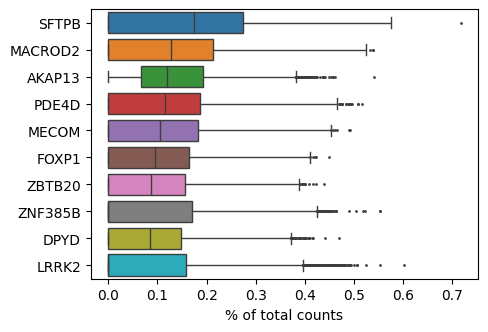

In [24]:
path="./GTEX-1HSMQ-5005.h5ad"
adata=ad.read_h5ad(path)
sc.pl.highest_expr_genes(adata,n_top=10)


Prikaz 10 najekspresivnijih gena čiji će UMAP grafici kasnije biti analizirani.

### Preprocessing

In [25]:
sc.pp.filter_cells(adata,min_genes=200)
sc.pp.filter_genes(adata,min_cells=3)

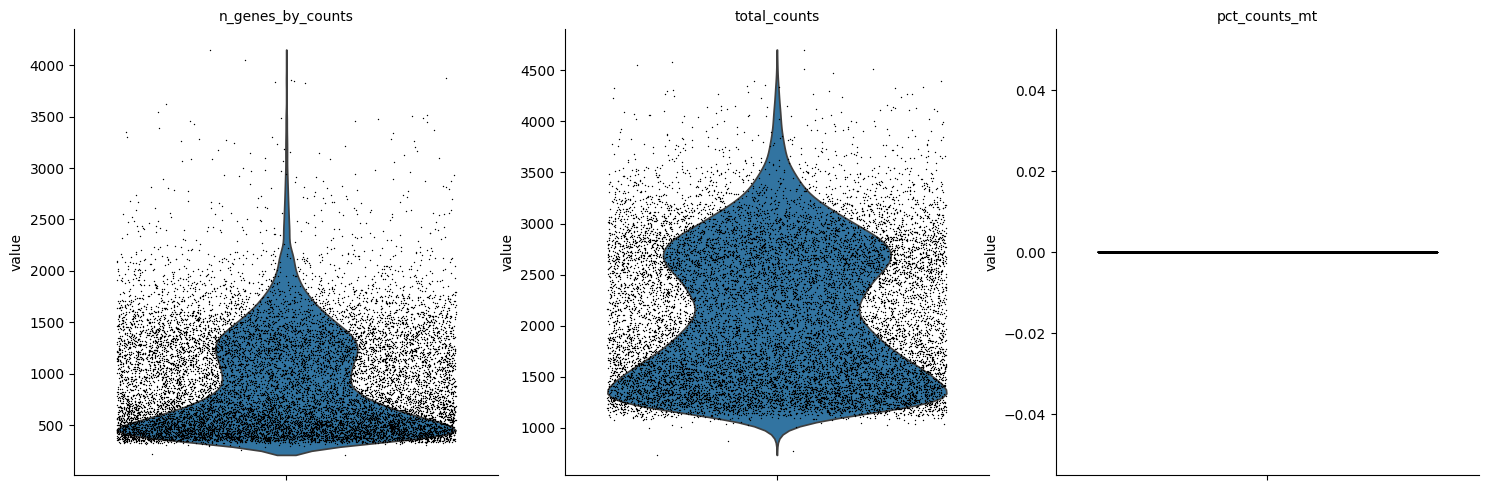

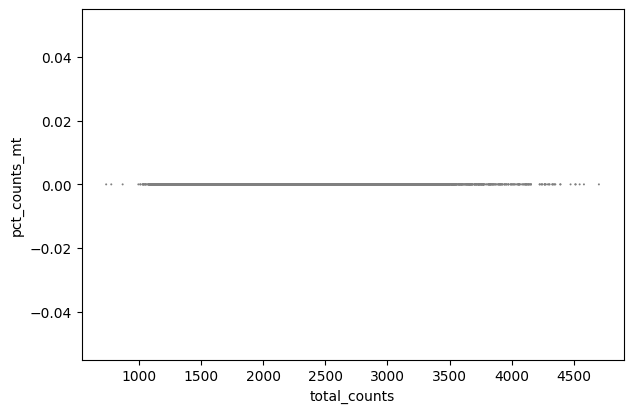

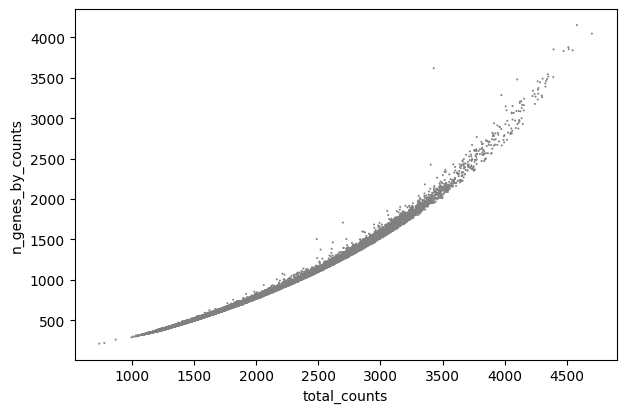

In [26]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Kako je procenat gena u mitohondrijama za svaku ćeliju jako mali, nije potrebno vršiti nikakvu filtraciju po tom pitanju.

In [27]:
adata = adata[adata.obs.n_genes_by_counts < 2400, :]

In [28]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

d:\MASTER\STUDIJE\GI\genomska\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


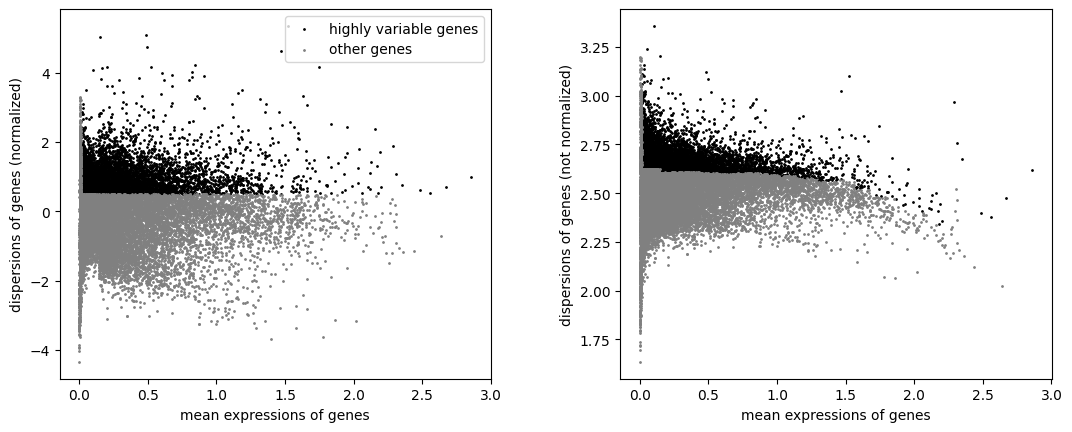

In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

Možemo videti da veoma varijabilni geni imaju veliku disperziju, međutim, dosta njih ima i prosečnu vrednost jako blizu nule.

In [30]:
sc.pp.scale(adata, max_value=10)

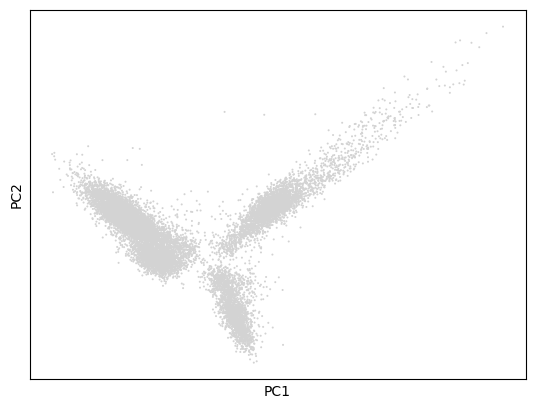

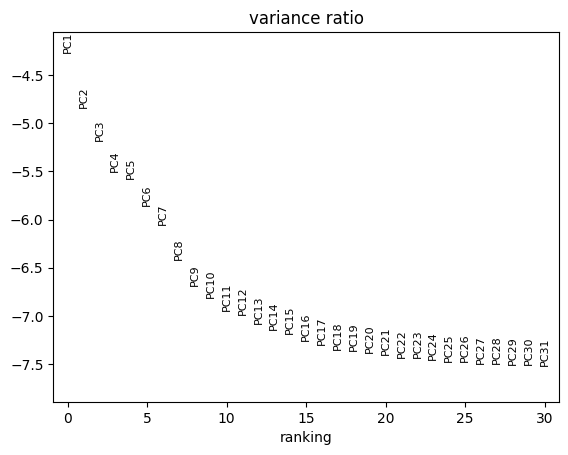

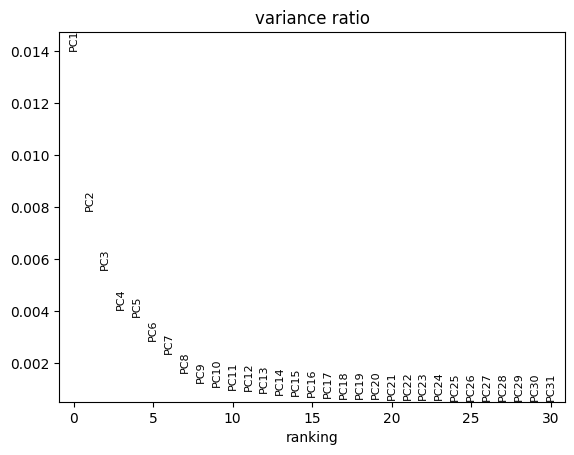

In [31]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca(adata)

sc.pl.pca_variance_ratio(adata, log=True)

sc.pl.pca_variance_ratio(adata)

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

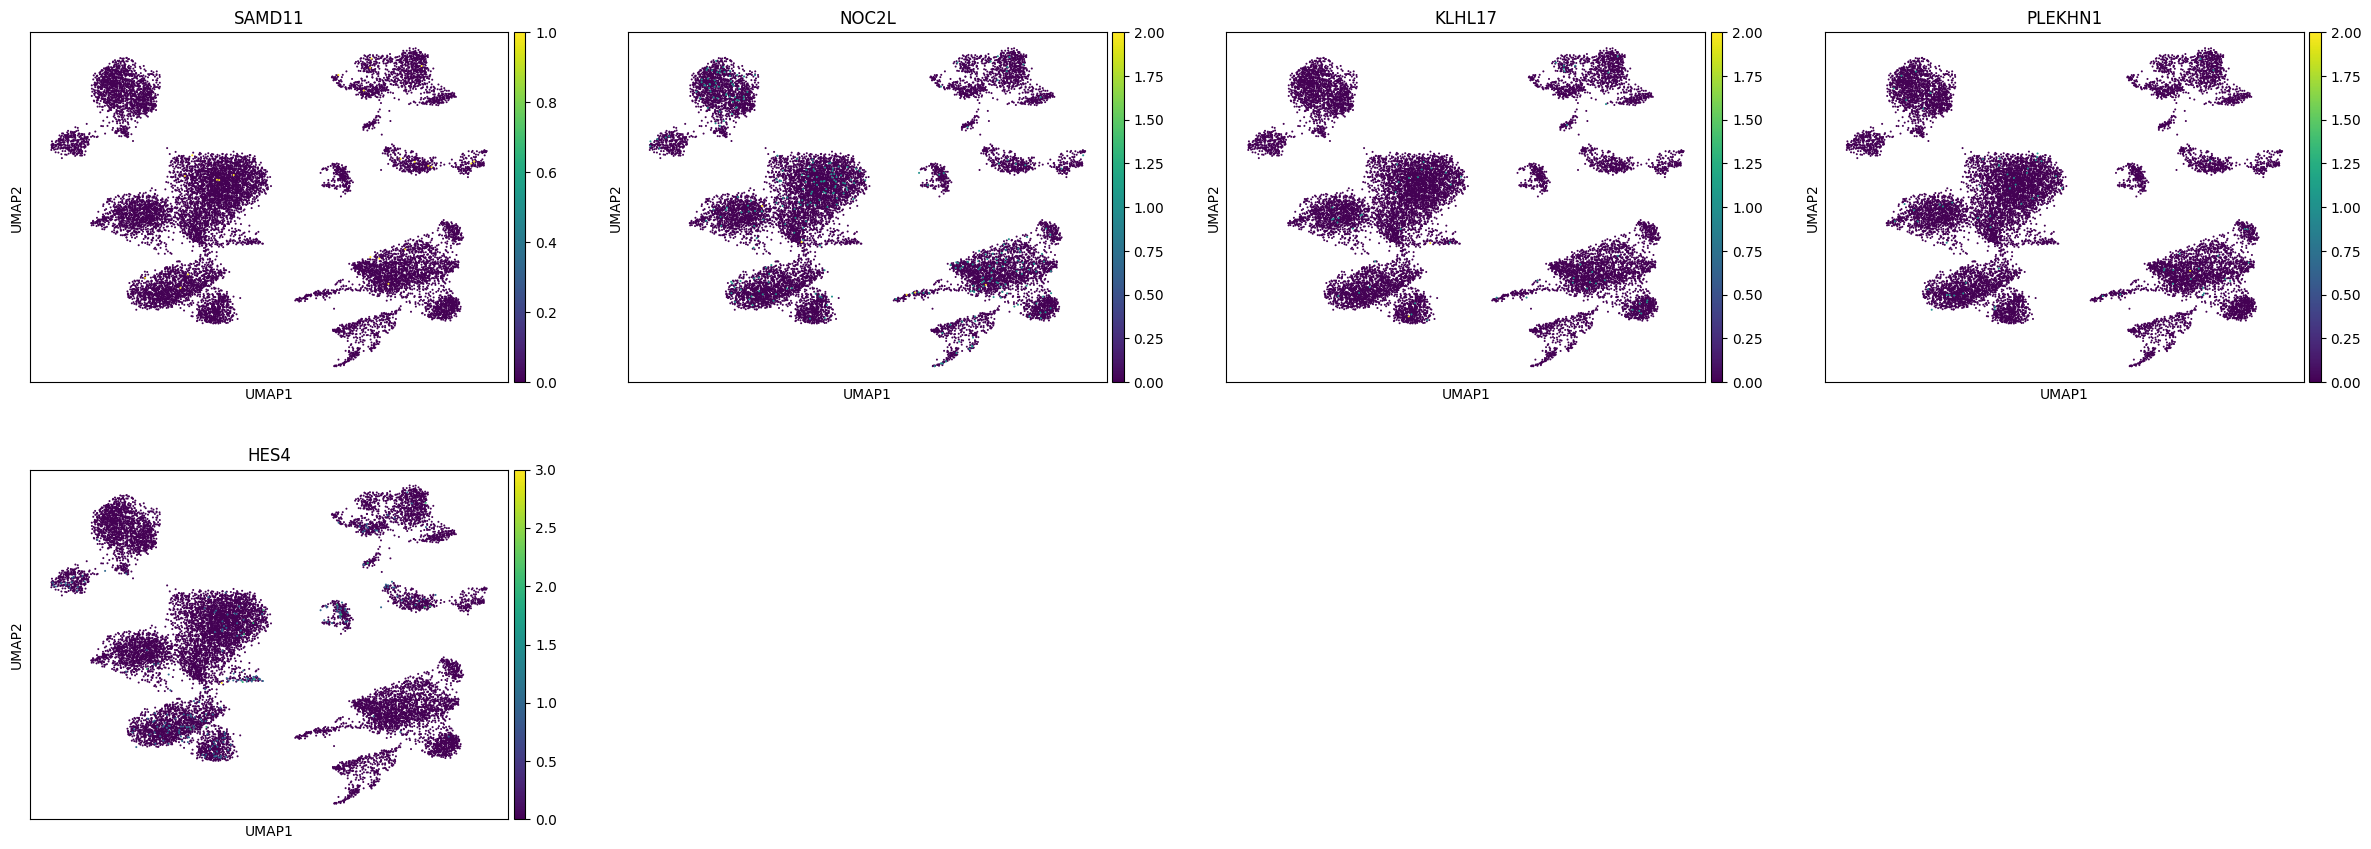

In [33]:
sc.tl.umap(adata)

top_genes = adata.var_names[adata.var.highly_variable]
top_genes = top_genes[:5]

sc.pl.umap(adata, color=top_genes)

Na graficima 5 najvarijabilnijih gena se ne može videti velika promena, većina vrednosti je jako blizu nule. To može biti posledica toga što većina visoko varijabilnih gena ima prosečnu vrednost jako blizu nule.

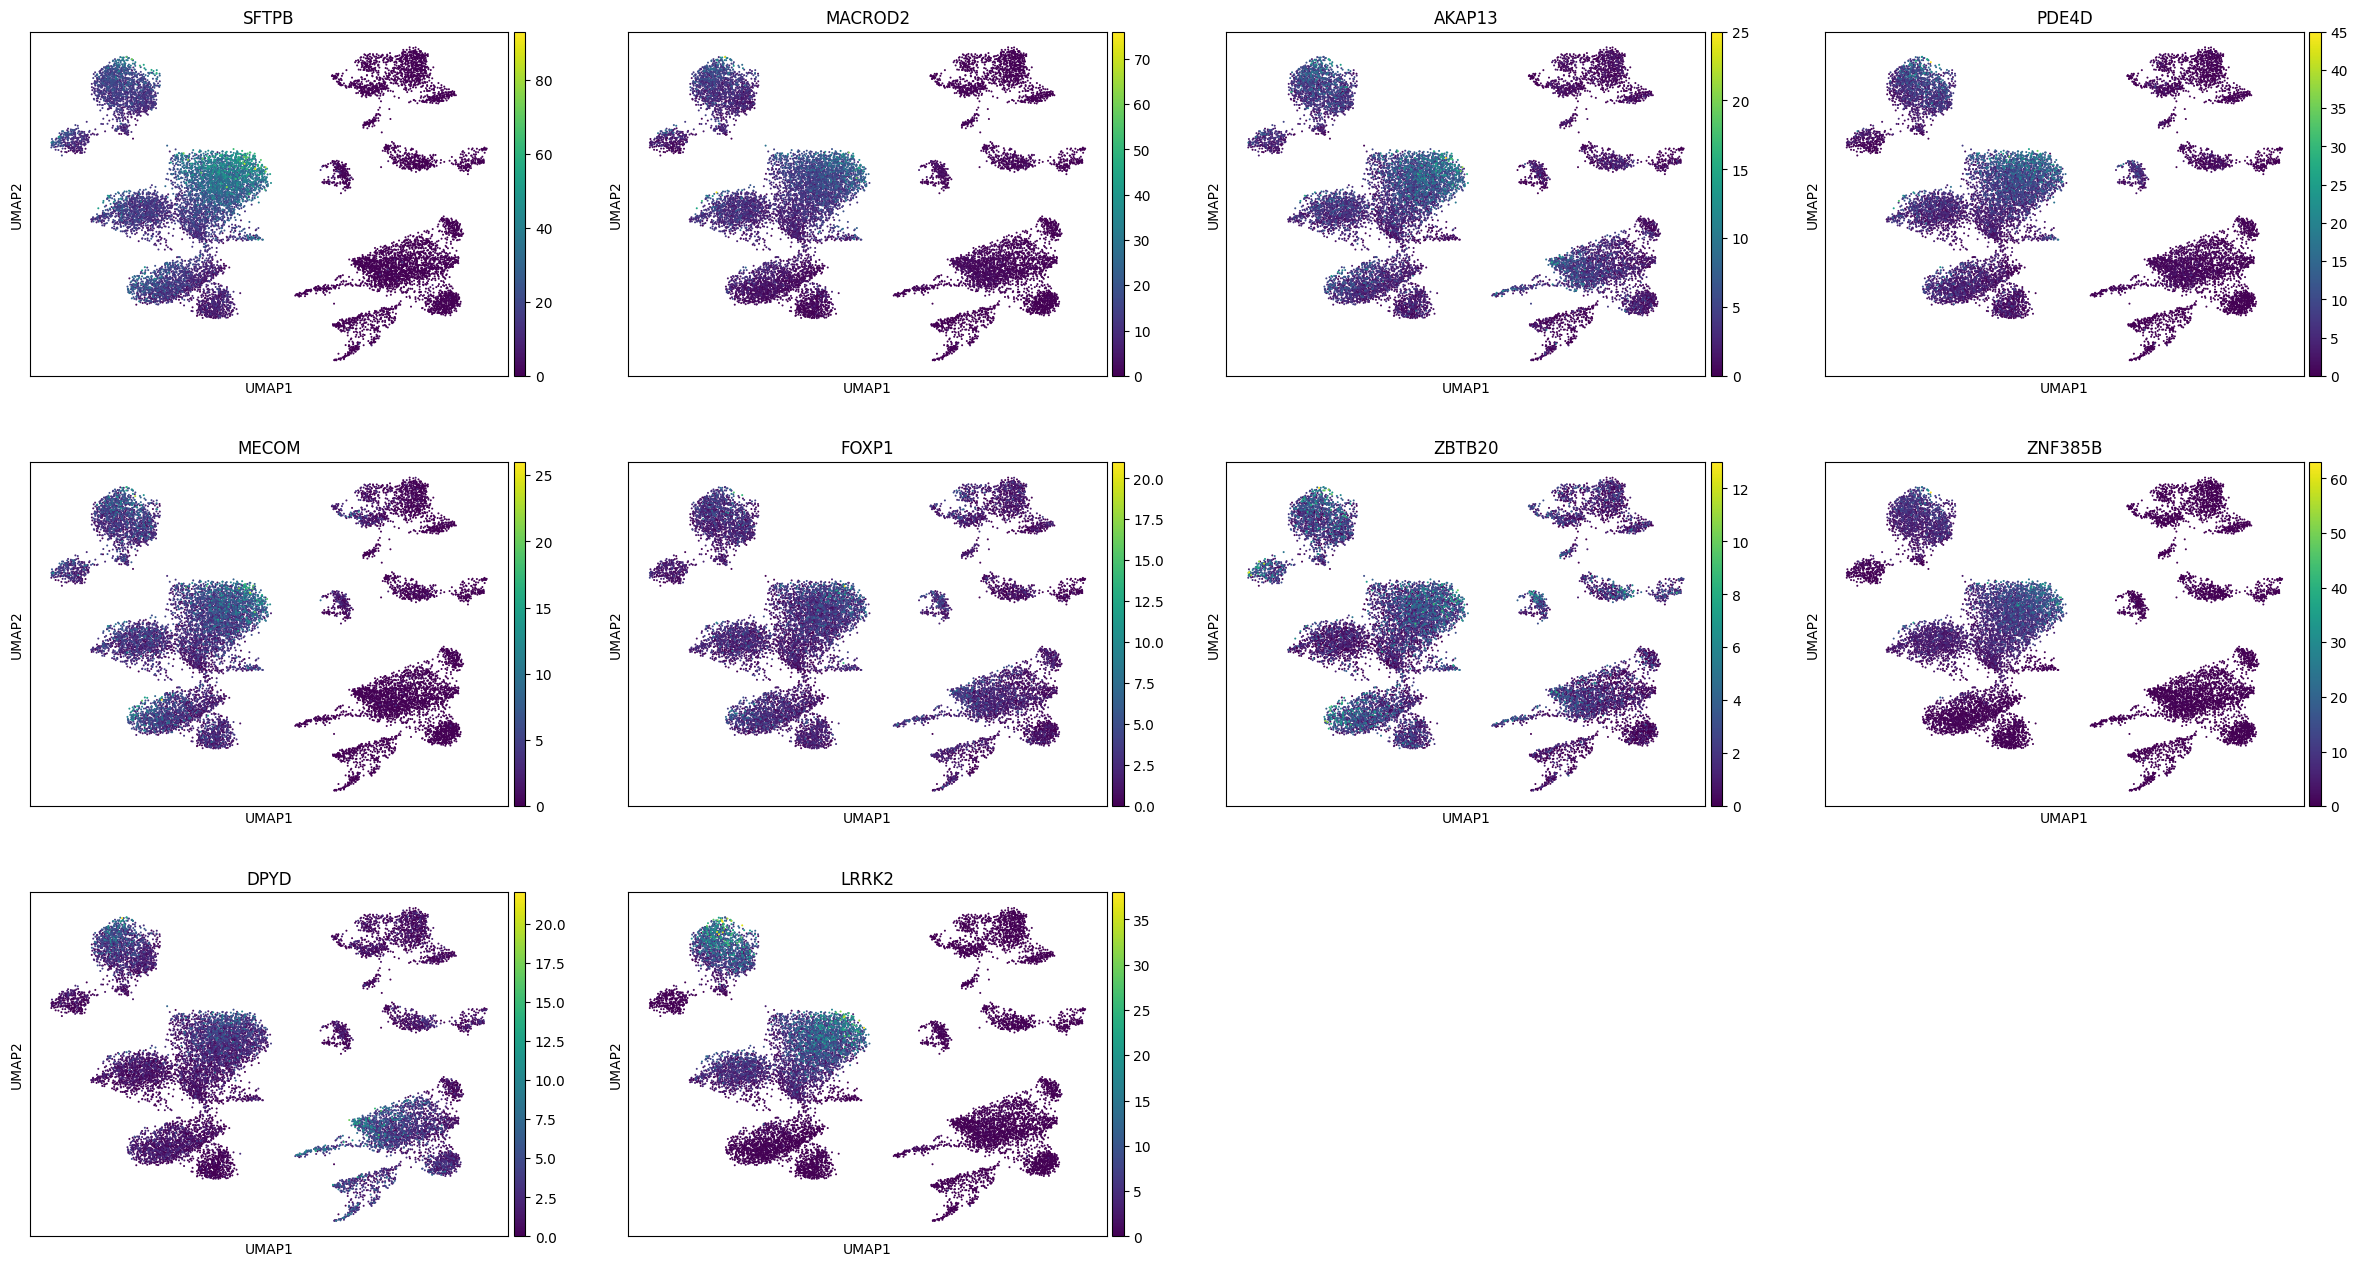

In [34]:
sc.pl.umap(adata, color=["SFTPB", "MACROD2", "AKAP13", "PDE4D", "MECOM", "FOXP1", "ZBTB20", "ZNF385B", "DPYD", "LRRK2"])

Za 10 najizraženijih gena možemo videti različit nivo ekspresije na različitim delovima (grupacijama) na grafiku što može ukazivati na različitu biološku funkciju.

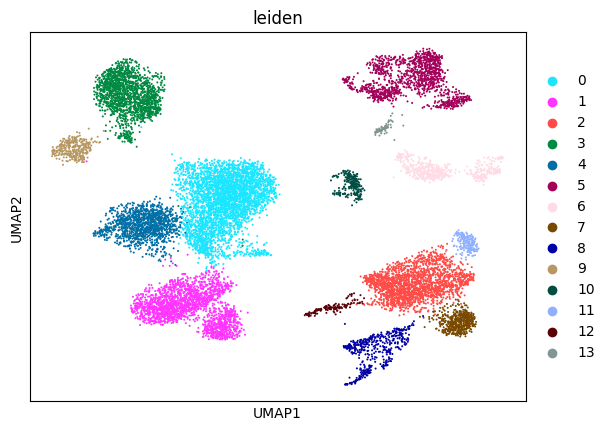

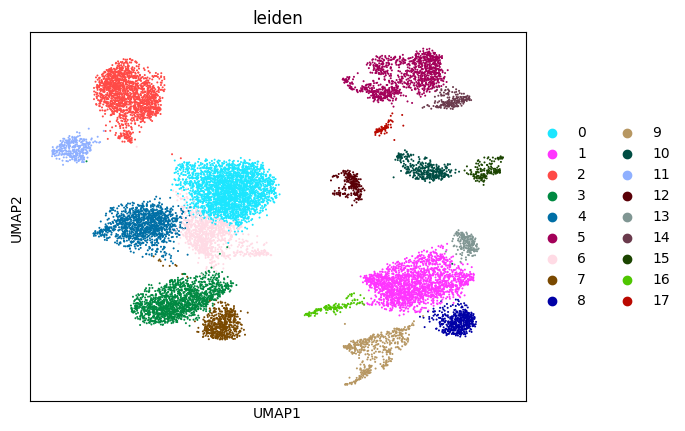

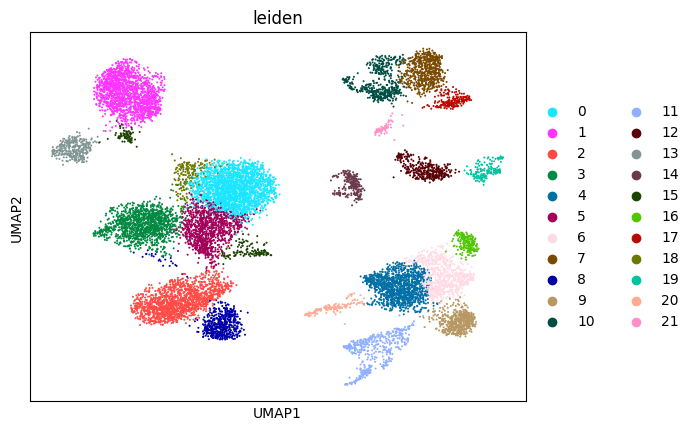

In [35]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color='leiden')

cluster_labels = {}
cluster_labels['0.3'] = adata.obs['leiden']

sc.tl.leiden(adata, resolution=0.9)
sc.pl.umap(adata, color='leiden')

cluster_labels['0.9'] = adata.obs['leiden']

sc.tl.leiden(adata, resolution=1.3)
sc.pl.umap(adata, color='leiden')

cluster_labels['1.3'] = adata.obs['leiden']

In [36]:
for key in cluster_labels:
    score = davies_bouldin_score(adata.X, cluster_labels[key])
    print(f"Resolution {key} has a Davies Bouldin score of {score}")

Resolution 0.3 has a Davies Bouldin score of 9.78051303163439
Resolution 0.9 has a Davies Bouldin score of 10.867305276357984
Resolution 1.3 has a Davies Bouldin score of 12.244902239269935


Ponavljanje analize, ali bez koraka za normalizaciju.

In [37]:
adata = ad.read_h5ad(path)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False,
    inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2400, :]

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.leiden(adata, resolution=0.3)

cluster_labels = {}
cluster_labels['0.3'] = adata.obs['leiden']

sc.tl.leiden(adata, resolution=0.9)

cluster_labels['0.9'] = adata.obs['leiden']

sc.tl.leiden(adata, resolution=1.3)

cluster_labels['1.3'] = adata.obs['leiden']

for key in cluster_labels:
    score = davies_bouldin_score(adata.X, cluster_labels[key])
    print(f"Resolution {key} has a Davies Bouldin score of {score}")

d:\MASTER\STUDIJE\GI\genomska\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


Resolution 0.3 has a Davies Bouldin score of 9.8353011655046
Resolution 0.9 has a Davies Bouldin score of 11.357193151538407
Resolution 1.3 has a Davies Bouldin score of 12.444153928648271


Možemo videti da u oba slučaja manje vrednosti rezolucije postižu manji (bolji) Davies Bouldin rezultat. Bolje vrednosti u sva tri slučaja su kada je izvršena normalizacija, ali ne znatno.